# Bag of pattern feature

Linear time method for classify time series using 1-NN approach. The method consist on generate all the sub-sequences of length $S$ from the timeseries, transforming each sub-sequence into a SAX word, generating a Bag-of-Patter representation.  

For irregular time series support the following modifications are made:

1. sub-sequence length will be defined based on time window instead of number of samples
2. sub-sequences with empty segments will be represented with special character on the SAX word.


## Step by step execution

Bag-of-Pattern features is a secuential process composed of several steps. Here we will show them based on the implemented source code using a **small dataset of regular time series**

In [1]:
import sys
import os
from collections import defaultdict
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("./Untitled.ipynb"), '..')))
import numpy as np
from src.bopf.bopf import BagOfPatternFeature
from src.utils import sort_trim_arr
from src.bopf.classifier import classify, classify2
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.stats import f_oneway
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

1. instanciate the main class

In [2]:
# special_character set to FALSE when using regular time series
bopf = BagOfPatternFeature(special_character=False)

2. load the dataset. In this case we will use Car dataset from UCR Archive which has 60 train samples and 60 test samples

In [3]:
%%time
# path windows
path = "../../UCRArchive_2018/FaceFour/FaceFour_TRAIN.tsv"
bopf.load_dataset(path, fmt="file")
print("train size:", bopf.m, "Ts len:", len(bopf.dataset[0]))

train size: 24 Ts len: 350
CPU times: user 13.9 ms, sys: 1.44 ms, total: 15.4 ms
Wall time: 24 ms


3. compute the CUMSUM matrix, needed for the linear time PAA computation.

In [4]:
%%time
bopf.cumsum()

CPU times: user 62.9 ms, sys: 412 µs, total: 63.3 ms
Wall time: 59.8 ms


4. get the bag-of-pattern representation for each time series. Input parameters are:

    - Word length (wd): the number of letter within each word
    - Sub-sequence width (wl): the size of each sub-sequence, input is a fraction ($[0, 1]$) of the whole time series width 

In [5]:
%%time
wd = 7
wl = 0.025
bopf.bop(wd, wl)

/home/frmunoz/Documents/tesis/src/bopf/bopf.py:313: RuntimeWarning: invalid value encountered in sqrt
  sigmax = np.sqrt(round(sumx2 / (seq_j-seq_i), 15) - round(meanx * meanx, 15))
/home/frmunoz/Documents/tesis/src/bopf/bopf.py:332: RuntimeWarning: divide by zero encountered in double_scalars
  paa = (avgsub - meanx) / sigmax


TOTAL DE SEGMENTOS VACIOS:  0
TOTAL DE TIMESERIES DESCARTADAS:  0
TOTAL DE ts < 6: 0
CPU times: user 593 ms, sys: 9.28 ms, total: 602 ms
Wall time: 598 ms


5. adjust the labels, getting the counts of time series on each class and an index array for each time series which lead to its label

In [6]:
%%time
bopf.adjust_label_set()

CPU times: user 1.56 ms, sys: 397 µs, total: 1.95 ms
Wall time: 1.55 ms


6. Perform ANOVA F Test for discriminating the best features of the bag-of-pattern representation

In [7]:
%%time
bopf.anova()

CPU times: user 1.68 s, sys: 17.8 ms, total: 1.7 s
Wall time: 1.68 s


In [8]:
%%time
bopf.anova_matrix()

CPU times: user 1.43 ms, sys: 10.3 ms, total: 11.7 ms
Wall time: 14 ms


7. drop all features with ANOVA F value 0 and sort the rest in decreasing order

In [9]:
%%time
bopf.anova_sort()
print("bopf features will be reduced from %d to %d" % (bopf.bopsize, bopf.fea_num))

bopf features will be reduced from 16384 to 1433
CPU times: user 8.27 ms, sys: 0 ns, total: 8.27 ms
Wall time: 5.98 ms


8. sort and trim the bag-of-pattern representation matrix of the whole dataset according tho the anova_sort

In [10]:
%%time
bopf.sort_trim_arr()

CPU times: user 89.2 ms, sys: 22.5 ms, total: 112 ms
Wall time: 88.5 ms


9. cross validate the accuracy of classification under leave-one-out method for the reduced bag-of-pattern representation, testing different combination of the top features. The cross validation is made under two different values:
    - cross validation using class centroids for classification
    - cross validation using class TF-IDF weights for classification

In [11]:
bopf.count_words_by_class()

In [12]:
%%time
# cross validation using centroids
bopf.cross_VL()
# print("best accuracy of CV: ", bopf.best_score, ", using the top", bopf.best_idx, "features according to ANOVA F")

CPU times: user 1.26 s, sys: 0 ns, total: 1.26 s
Wall time: 1.26 s


In [12]:
%%time
# cross validation using centroids
bopf.crossVL(verbose=False)
print("best accuracy of CV: ", bopf.best_score, ", using the top", bopf.best_idx, "features according to ANOVA F")

best accuracy of CV:  0.9166666666666666 , using the top 14 features according to ANOVA F
CPU times: user 1.28 s, sys: 9.08 ms, total: 1.29 s
Wall time: 1.28 s


In [13]:
%%time
# cross validation using tf-idf
bopf.crossVL2()
print("best accuracy of CV2: ", bopf.best2_score, ", using the top", bopf.best2_idx, "features according to ANOVA F")

best accuracy of CV2:  1.0 , using the top 1433 features according to ANOVA F
CPU times: user 1.83 s, sys: 0 ns, total: 1.83 s
Wall time: 1.83 s


10. classify a test set using the best configuration for centroids or tf-idf

In [14]:
from src.bopf.classifier import classify, classify2
from src.utils import sort_trim_arr

In [15]:
# load the test set
bopf_t = BagOfPatternFeature(special_character=False)
path_t = "../../UCRArchive_2018/FaceFour/FaceFour_TEST.tsv"
bopf_t.load_dataset(path_t, fmt="file")

# compute CUMSUM matrix for test set
bopf_t.cumsum()

# compute bag-of-pattern representation for test set
bopf_t.bop(wd, wl)

# sort and trim the bag-of-pattern representation based on the centroid best configuration
test_bop_sort = sort_trim_arr(bopf_t.train_bop, bopf.sort_index[:bopf.best_idx], 
                                  bopf_t.m, bopf.best_idx)
# classify to get predicted labels
predicted_label = classify(test_bop_sort, bopf.crossL[:bopf. c*bopf.best_idx], bopf.tlabel, 
                               bopf_t.m, bopf.c, bopf.best_idx)

# get real labels of test set
real_label = np.array(bopf_t.labels)

# compute accuracy
count = 0
for i in range(len(real_label)):
    if predicted_label[i] == real_label[i]:
        count += 1

acc = count / bopf_t.m
print("accuracy of classify using wd:", wd, ", wl:", wl, ", and best config for centroids is:", acc)

### repeat for tf-idf

# sort and trim the bag-of-pattern representation based on the centroid best configuration
test_bop_sort2 = sort_trim_arr(bopf_t.train_bop, bopf.sort_index[:bopf.best2_idx], 
                                  bopf_t.m, bopf.best2_idx)
# classify to get predicted labels
predicted_label2 = classify2(test_bop_sort2, bopf.crossL2[:bopf.c*bopf.best2_idx], bopf.tlabel, 
                               bopf_t.m, bopf.c, bopf.best2_idx)

# compute accuracy
count = 0
for i in range(len(real_label)):
    if predicted_label2[i] == real_label[i]:
        count += 1
        
acc2 = count / len(real_label)
print("accuracy of classify using wd:", wd, ", wl:", wl, ", and best config for tf-idf is:", acc2)

/home/frmunoz/Documents/tesis/src/bopf/bopf.py:332: RuntimeWarning: invalid value encountered in double_scalars
  paa = (avgsub - meanx) / sigmax


TOTAL DE SEGMENTOS VACIOS:  0
TOTAL DE TIMESERIES DESCARTADAS:  0
TOTAL DE ts < 6: 0
accuracy of classify using wd: 7 , wl: 0.025 , and best config for centroids is: 0.4772727272727273
accuracy of classify using wd: 7 , wl: 0.025 , and best config for tf-idf is: 0.48863636363636365


## Looking for best parameters

for best accuracy the combination parameter (wd, wl) has to be improved. In order to achive that, a number of word length ans sub-sequence width are defined and every combination is testes choosing the bests based on cross validation results.

On paper they propose:

    - wd: {3, 4, 5, 6, 7}
    - wl: {0.025, 0.05, 0.075, ..., 1}
    
and we will execute our code over UCR datasets used on the paper, looking for a resulting accuracy simmilar to the ones presented on the paper

In [16]:
wd_arr = [3, 4, 5, 6, 7]
step = 0.05
wl_arr = np.round((np.arange(int(1/step))+1)*step, 2)


def classify_v2(test_bop, centroids, tlabel, mt, c, fea_num):
    res = np.zeros(mt, dtype=int)
    for i in range(mt):
        rmin = np.inf
        label = -1
        for j in range(c):
            r = 0.0
            dist = 0
            for k in range(fea_num):
                q = test_bop[i + (k) * mt]
                s = centroids[j + (k) * c]
                dist += (q - s) ** 2
            if dist < rmin:
                rmin = dist
                label = tlabel[j]
        res[i] = label

    return res

def main_test_ucr_p1(train_file, test_file, wd_arr, wl_arr):
    wd_num = len(wd_arr)
    wl_num = len(wl_arr)
    
    bopf = BagOfPatternFeature(special_character=False)
    bopf.load_dataset(train_file, fmt="file")
    bopf.cumsum()
    
    bopf_t = BagOfPatternFeature(special_character=False)
    bopf_t.load_dataset(test_file, fmt="file")
    bopf_t.cumsum()
    
    output_dict = defaultdict(list)
    
    for i in range(wd_num):
        wd = wd_arr[i]
        for j in range(wl_num):
            wl = wl_arr[j]
            print("wd: {}".format(wd) + ", wl: {}".format(wl), end="\r")
            bopf.bop(wd, wl, verbose=False)
            bopf.adjust_label_set()
            bopf.anova(verbose=False)
            bopf.anova_sort()
            bopf.sort_trim_arr(verbose=False)
            
            bopf.crossVL(verbose=False)
            output_dict["bop_features"].append(bopf.crossL[:bopf.c*bopf.best_idx])
            output_dict["bop_fea_num"].append(bopf.best_idx)
            output_dict["bop_cv_acc"].append(bopf.best_score)
            output_dict["bop_feature_index"].append(bopf.sort_index[:bopf.best_idx])
            
            bopf.crossVL2()
            output_dict["bop_features2"].append(bopf.crossL2[:bopf.c*bopf.best2_idx])
            output_dict["bop_fea_num2"].append(bopf.best2_idx)
            output_dict["bop_cv_acc2"].append(bopf.best2_score)
            output_dict["bop_feature_index2"].append(bopf.sort_index[:bopf.best2_idx])
            
            output_dict["bop_wd"].append(wd)
            output_dict["bop_wl"].append(wl)
            
    print("wd: {}".format(wd) + ", wl: {0:.2f}".format(wl))
    return bopf, bopf_t, output_dict
    
def main_test_ucr_p2(bopf, bopf_t, output_dict, top_n):
    index1 = np.argsort(output_dict["bop_cv_acc"])[::-1]
    index2 = np.argsort(output_dict["bop_cv_acc2"])[::-1]

#     avg_acc_sum = 0
#     avg_acc_sum2 = 0
#     for i in range(top_n):
#         avg_acc_sum += output_dict["bop_cv_acc"][index1[i]]
#         avg_acc_sum2 += output_dict["bop_cv_acc2"][index2[i]]

#     avg_acc = avg_acc_sum / top_n
#     avg_acc2 = avg_acc_sum2 / top_n
#     if avg_acc > avg_acc2:
        # classify using centroid
    best_centroid = -1
    best_tf_idf = -1
    rbest_centroid = -np.inf
    rbest_tf_idf = -np.inf
    for i in range(top_n):
        print(i, end="\r")
        s_index = index1[i]
        wd = output_dict["bop_wd"][s_index]
        wl = output_dict["bop_wl"][s_index]
        bopf_t.bop(wd, wl, verbose=False)
        test_bop_sort = sort_trim_arr(bopf_t.train_bop, output_dict["bop_feature_index"][s_index], 
                                  bopf_t.m, output_dict["bop_fea_num"][s_index])
        predicted_label = classify_v2(test_bop_sort, output_dict["bop_features"][s_index], bopf.tlabel, 
                               bopf_t.m, bopf.c, output_dict["bop_fea_num"][s_index])
        real_label = np.array(bopf_t.labels)
        count = 0
        for j in range(len(real_label)):
            if predicted_label[j] == real_label[j]:
                count += 1
        acc = count / len(real_label)
        if acc > rbest_centroid:
            rbest_centroid = acc
            best_centroid = i
    s_index = index1[best_centroid]
    print("classify with best centroid and wd:", output_dict["bop_wd"][s_index], 
          ", wl:", output_dict["bop_wl"][s_index], 
          "-> cv_acc:", round(output_dict["bop_cv_acc"][s_index], 3),
          ", acc:", round(rbest_centroid, 3))
    
#     else:
    # classify using tf-idf
    # classify using centroid
    for i in range(top_n):
        print(i, end="\r")
        s_index = index2[i]
        wd = output_dict["bop_wd"][s_index]
        wl = output_dict["bop_wl"][s_index]
        bopf_t.bop(wd, wl, verbose=False)
        test_bop_sort = sort_trim_arr(bopf_t.train_bop, output_dict["bop_feature_index2"][s_index], 
                              bopf_t.m, output_dict["bop_fea_num2"][s_index])
        predicted_label = classify2(test_bop_sort, output_dict["bop_features2"][s_index], bopf.tlabel, 
                           bopf_t.m, bopf.c, output_dict["bop_fea_num2"][s_index])
        real_label = np.array(bopf_t.labels)
        count = 0
        for j in range(len(real_label)):
            if predicted_label[j] == real_label[j]:
                count += 1
        acc = count / len(real_label)
        if acc > rbest_tf_idf:
            rbest_tf_idf = acc
            best_tf_idf = i
            
    s_index = index2[best_tf_idf]
    print("classify with best tf-idf and wd:", output_dict["bop_wd"][s_index], 
          ", wl:", output_dict["bop_wl"][s_index], 
          "-> cv_acc:", round(output_dict["bop_cv_acc2"][s_index], 3),
          ", acc:", round(rbest_tf_idf, 3))
    
    if rbest_centroid > rbest_tf_idf:
        s_index = index1[best_centroid]
        pred_label = classify_v2(test_bop_sort, output_dict["bop_features"][s_index], bopf.tlabel, 
                               bopf_t.m, bopf.c, output_dict["bop_fea_num"][s_index])
        acc = rbest_centroid
    else:
        s_index = index2[best_tf_idf]
        pred_label = classify2(test_bop_sort, output_dict["bop_features2"][s_index], bopf.tlabel, 
                           bopf_t.m, bopf.c, output_dict["bop_fea_num2"][s_index])
        acc = rbest_tf_idf
        
    return pred_label, real_label, acc

## Control tests on regular datasets

we will do some sanity checks by comparing accuracy of our implementation with the paper's results for the same datasets. Dataset used will be:

- FaceFour
- BeetleFly
- Car
- Haptics

all of them can be founde on [UCR Archive](https://www.cs.ucr.edu/~eamonn/time_series_data_2018/)

### FaceFour dataset

In [13]:
%%time
train_file = "D:/tesis/UCRArchive_2018/FaceFour/FaceFour_TRAIN.tsv"
test_file = "D:/tesis/UCRArchive_2018/FaceFour/FaceFour_TEST.tsv"
wd_arr = [3, 4, 5, 6, 7]
step = 0.025
wl_arr = np.round((np.arange(int(1/step))+1)*step, 3)
bopf3, bopf_t3, output_dict3 = main_test_ucr_p1(train_file, test_file, wd_arr, wl_arr)

D:\tesis\tesis\src\bopf\bopf.py:226: RuntimeWarning: invalid value encountered in sqrt
  sigmax = np.sqrt(round(sumx2 / (seq_j-seq_i), 15) - round(meanx * meanx, 15))
D:\tesis\tesis\src\bopf\bopf.py:244: RuntimeWarning: divide by zero encountered in double_scalars
  paa = (avgsub - meanx) / sigmax


wd: 7, wl: 1.005
Wall time: 2min 11s


In [21]:
top_n = 50
main_test_ucr_p2(bopf3, bopf_t3, output_dict3, top_n)

classify with best centroid and wd: 4 , wl: 0.425 -> cv_acc: 1.0 , acc: 0.955


D:\tesis\tesis\src\bopf\bopf.py:191: RuntimeWarning: invalid value encountered in double_scalars
  paa = (avgsub - meanx) / sigmax


classify with best tf-idf and wd: 4 , wl: 0.475 -> cv_acc: 1.0 , acc: 0.852


### BeetleFly dataset

In [22]:
%%time
train_file = "D:/tesis/UCRArchive_2018/BeetleFly/BeetleFly_TRAIN.tsv"
test_file = "D:/tesis/UCRArchive_2018/BeetleFly/BeetleFly_TEST.tsv"
wd_arr = [3, 4, 5, 6, 7]
step = 0.025
wl_arr = np.round((np.arange(int(1/step))+1)*step, 3)
bopf0, bopf_t0, output_dict0 = main_test_ucr_p1(train_file, test_file, wd_arr, wl_arr)

wd: 7, wl: 1.005
Wall time: 2min 3s


In [23]:
%%time
top_n = 50
main_test_ucr_p2(bopf0, bopf_t0, output_dict0, top_n)

classify with best centroid and wd: 5 , wl: 0.175 -> cv_acc: 1.0 , acc: 0.85


D:\tesis\tesis\src\bopf\classifier.py:55: RuntimeWarning: invalid value encountered in double_scalars
  r = r1 * r1 / (r2 * r3)


classify with best tf-idf and wd: 5 , wl: 0.8 -> cv_acc: 1.0 , acc: 0.6
Wall time: 35 s


### Car dataset

In [20]:
%%time
train_file = "../../UCRArchive_2018/Car/Car_TRAIN.tsv"
test_file = "../../UCRArchive_2018/Car/Car_TEST.tsv"
wd_arr = [3, 4, 5, 6, 7]
step = 0.025
wl_arr = np.round((np.arange(int(1/step))+1)*step, 3)
bopf1, bopf_t1, output_dict1 = main_test_ucr_p1(train_file, test_file, wd_arr, wl_arr)

wd: 7, wl: 1.005
CPU times: user 9min 33s, sys: 239 ms, total: 9min 33s
Wall time: 9min 34s


In [40]:
top_n = 50
pred_modified, test_modified, acc_modified = main_test_ucr_p2(bopf1, bopf_t1, output_dict1, top_n)

classify with best centroid and wd: 7 , wl: 0.175 -> cv_acc: 0.9 , acc: 0.85
classify with best tf-idf and wd: 6 , wl: 0.85 -> cv_acc: 0.833 , acc: 0.483


In [58]:
wd = 7
wl = 0.175
s_index = 166
bopf_t1.bop(wd, wl, verbose=False)
test_bop_sort = sort_trim_arr(bopf_t1.train_bop, output_dict1["bop_feature_index"][s_index], 
                              bopf_t1.m, output_dict1["bop_fea_num"][s_index])
pred_modified = classify_v2(test_bop_sort, output_dict1["bop_features"][s_index], bopf1.tlabel, 
                               bopf_t1.m, bopf1.c, output_dict1["bop_fea_num"][s_index])
pred_modified

array([4, 3, 2, 3, 4, 3, 1, 4, 2, 3, 1, 1, 1, 3, 4, 3, 3, 4, 2, 4, 2, 2,
       3, 2, 3, 2, 3, 3, 1, 2, 4, 1, 1, 1, 1, 3, 1, 3, 1, 3, 2, 2, 3, 2,
       2, 2, 3, 3, 2, 3, 3, 2, 1, 1, 2, 1, 1, 4, 3, 4])

### Extra check: comparison in confusion matrix

Normalized confusion matrix
              precision    recall  f1-score   support

           1       1.00      0.93      0.96        14
           2       1.00      0.93      0.96        14
           3       0.61      0.58      0.59        19
           4       0.44      0.54      0.48        13

    accuracy                           0.73        60
   macro avg       0.76      0.74      0.75        60
weighted avg       0.75      0.73      0.74        60

Normalized confusion matrix
              precision    recall  f1-score   support

           1       0.80      0.86      0.83        14
           2       0.88      1.00      0.93        14
           3       0.85      0.89      0.87        19
           4       0.89      0.62      0.73        13

    accuracy                           0.85        60
   macro avg       0.85      0.84      0.84        60
weighted avg       0.85      0.85      0.84        60



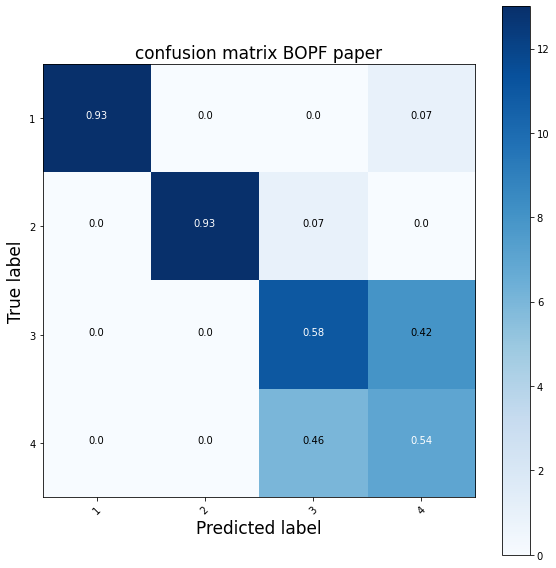

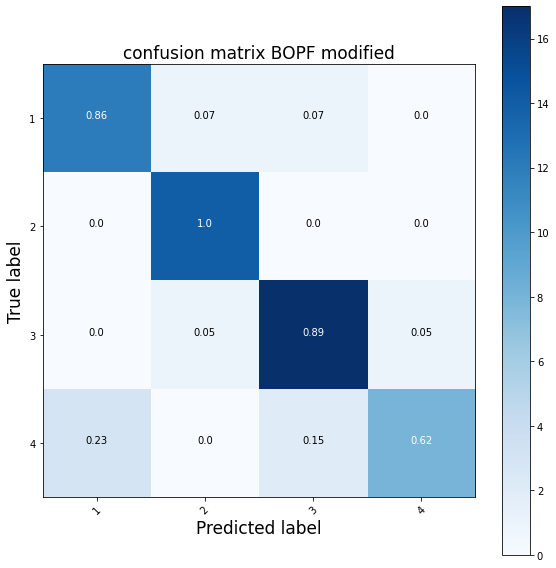

In [59]:
pred_test_car_paper = [(3,4),(3,3),(2,2),(3,3),(3,4),(3,3),(4,4),(4,4),(2,2),(3,4),(1,1),
                       (1,1),(4,1),(4,3),(3,4),(3,3),(3,3),(4,4),(2,2),(4,4),(2,2),(2,2),
                       (4,3),(2,2),(3,3),(2,2),(3,3),(4,3),(1,1),(2,2),(3,4),(1,1),(4,4),
                       (1,1),(3,4),(4,3),(1,1),(3,3),(1,1),(3,3),(3,2),(2,2),(3,3),(2,2),
                       (2,2),(2,2),(4,3),(4,3),(1,1),(1,1),(4,4),(3,3),(1,1),(1,1),(2,2),
                       (1,1),(1,1),(4,3),(4,3),(4,4),]
pred_paper = []
test_paper = []
for x in pred_test_car_paper:
    pred_paper.append(x[0])
    test_paper.append(x[1])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)



cnf_matrix = confusion_matrix(test_paper, pred_paper)
np.set_printoptions(precision=2)

cnf_matrix2 = confusion_matrix(test_modified, pred_modified)
np.set_printoptions(precision=2)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, bopf1.tlabel, normalize=True,
                      title='confusion matrix BOPF paper')

print(classification_report(test_paper, pred_paper))

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix2, bopf1.tlabel, normalize=True,
                      title='confusion matrix BOPF modified')

print(classification_report(test_modified, pred_modified))


### Haptics dataset

In [27]:
%%time
train_file = "D:/tesis/UCRArchive_2018/Haptics/Haptics_TRAIN.tsv"
test_file = "D:/tesis/UCRArchive_2018/Haptics/Haptics_TEST.tsv"
wd_arr = [3, 4, 5, 6, 7]
step = 0.025
wl_arr = np.round((np.arange(int(1/step))+1)*step, 3)
bopf4, bopf_t4, output_dict4 = main_test_ucr_p1(train_file, test_file, wd_arr, wl_arr)

wd: 7, wl: 1.005
Wall time: 36min 52s


In [29]:
%%time
top_n = 50
main_test_ucr_p2(bopf4, bopf_t4, output_dict4, top_n)

classify with best centroid and wd: 5 , wl: 0.775 -> cv_acc: 0.555 , acc: 0.36
classify with best tf-idf and wd: 7 , wl: 0.45 -> cv_acc: 0.723 , acc: 0.224
Wall time: 33min 45s


### Comparing paper vs our results

| Dataset | Accuracy paper | Accuracy us |
| :-: | :-: | :-: |
| FaceFour | 1 | 0.96 |
| BeetleFly | 0.8 | 0.85|
| Car | 0.73 | 0.68 |
| Haptics | 0.42 | 0.36|

At most 6% difference is probably due to difference in sorting algorithms. To check this problem should use stable_sort on bot my python implementation and the author's implementation in c++

## Application to irregular time series

### Simple case execution

In [19]:
bopf = BagOfPatternFeature(special_character=True)
path = "D:/tesis/tesis/data/plasticc_sub_dataset/"
bopf.load_dataset(path, fmt="npy", set_type="train", n1=100, n2=100, c=4)
print("train size:", bopf.m)
bopf.cumsum()
wd = 7 
wl = 0.325

print("computing BOP...", end="")
ini = time.time()
bopf.bop(wd, wl, verbose=False)
end = time.time()
print("DONE, time:", end - ini)

print("adjusting labels...", end="")
ini = time.time()
bopf.adjust_label_set()
end = time.time()
print("DONE, time:", end - ini)

print("computing ANOVA...", end="")
ini = time.time()
bopf.anova_matrix(verbose=False)
end = time.time()
print("DONE, time:", end - ini)

print("sorting ANOVA values...", end="")
ini = time.time()
bopf.anova_sort()
end = time.time()
print("DONE, time:", end - ini)

print("sort BOP representation...", end="")
ini = time.time()
bopf.sort_trim_arr(verbose=False)
end = time.time()
print("DONE, time:", end - ini)

print("count words by class...", end="")
ini = time.time()
bopf.count_words_by_class()
end = time.time()
print("DONE, time:", end - ini)

print("first cross VL ...", end="")
ini = time.time()
bopf.crossVL(verbose=False)
# bopf.cross_VL()
end = time.time()
print("DONE, time:", end - ini)

print("best accuracy of CV: ", bopf.best_score, ", using the top", bopf.best_idx, "features according to ANOVA F")
print("second cross VL ...", end="")
ini = time.time()
bopf.crossVL2()
end = time.time()
print("DONE, time:", end - ini)
print("best accuracy of CV2: ", bopf.best2_score, ", using the top", bopf.best2_idx, "features according to ANOVA F")


# load the test set
bopf_t = BagOfPatternFeature(special_character=True)
bopf_t.load_dataset(path, fmt="npy", set_type="test", n1=100, n2=100, c=4)

# compute CUMSUM matrix for test set
bopf_t.cumsum()

# compute bag-of-pattern representation for test set
bopf_t.bop(wd, wl, verbose=False)

# sort and trim the bag-of-pattern representation based on the centroid best configuration
test_bop_sort = sort_trim_arr(bopf_t.train_bop, bopf.sort_index[:bopf.best_idx], 
                                  bopf_t.m, bopf.best_idx)
# classify to get predicted labels
predicted_label = classify(test_bop_sort, bopf.crossL[:bopf. c*bopf.best_idx], bopf.tlabel, 
                               bopf_t.m, bopf.c, bopf.best_idx)

# get real labels of test set
real_label = np.array(bopf_t.labels)

# compute accuracy
count = 0
for i in range(len(real_label)):
    if predicted_label[i] == real_label[i]:
        count += 1

acc = count / bopf_t.m
print("accuracy of classify using wd:", wd, ", wl:", wl, ", and best config for centroids is:", acc)

### repeat for tf-idf

# sort and trim the bag-of-pattern representation based on the centroid best configuration
test_bop_sort2 = sort_trim_arr(bopf_t.train_bop, bopf.sort_index[:bopf.best2_idx], 
                                  bopf_t.m, bopf.best2_idx)
# classify to get predicted labels
predicted_label2 = classify2(test_bop_sort2, bopf.crossL2[:bopf.c*bopf.best2_idx], bopf.tlabel, 
                               bopf_t.m, bopf.c, bopf.best2_idx)

# compute accuracy
count = 0
for i in range(len(real_label)):
    if predicted_label2[i] == real_label[i]:
        count += 1
        
acc2 = count / len(real_label)
print("accuracy of classify using wd:", wd, ", wl:", wl, ", and best config for tf-idf is:", acc2)

train size: 100
computing BOP...DONE, time: 0.05485343933105469
adjusting labels...DONE, time: 0.0009975433349609375
computing ANOVA...DONE, time: 0.09773826599121094
sorting ANOVA values...DONE, time: 0.04089069366455078
sort BOP representation...DONE, time: 1.347398042678833
count words by class...DONE, time: 0.0009975433349609375
first cross VL ...DONE, time: 48.180224657058716
best accuracy of CV:  0.53 , using the top 65093 features according to ANOVA F
second cross VL ...DONE, time: 104.6552460193634
best accuracy of CV2:  0.97 , using the top 65501 features according to ANOVA F
accuracy of classify using wd: 7 , wl: 0.325 , and best config for centroids is: 0.24
accuracy of classify using wd: 7 , wl: 0.325 , and best config for tf-idf is: 0.17


## Experimental evaluation on sub-datasets from PLaSTiCC

for faster execution the experiments where performed on terminal using multiprocessing and here we will show the results

In [23]:
df = pd.read_csv("D:/tesis/tesis/data/bop_plasticc_results.csv")
df

,#n1,n2,c,acc,wd,wl,train_time,test_time
0,100,25,6,0.360,7,0.150,518.851137,13.849060
1,500,125,6,0.376,5,0.700,3500.945935,142.166485
2,1000,250,6,0.404,3,0.850,7773.627838,380.598793
3,2000,500,6,0.390,3,0.875,19276.173855,898.231979
4,4000,1000,6,0.392,3,0.850,43500.916891,2045.043403


Observation: the test part was executed without multiprocessig

### Getting confusion matrix for dataset 4000/1000

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

0.3875
accuracy [4000/1000]:  0.392
Normalized confusion matrix
              precision    recall  f1-score   support

        15.0       0.00      0.00      0.00        77
        16.0       0.33      0.50      0.40       145
        42.0       0.00      0.00      0.00       187
        62.0       0.00      0.00      0.00        76
        65.0       0.00      0.00      0.00       153
        90.0       0.41      0.88      0.56       362

    accuracy                           0.39      1000
   macro avg       0.12      0.23      0.16      1000
weighted avg       0.20      0.39      0.26      1000



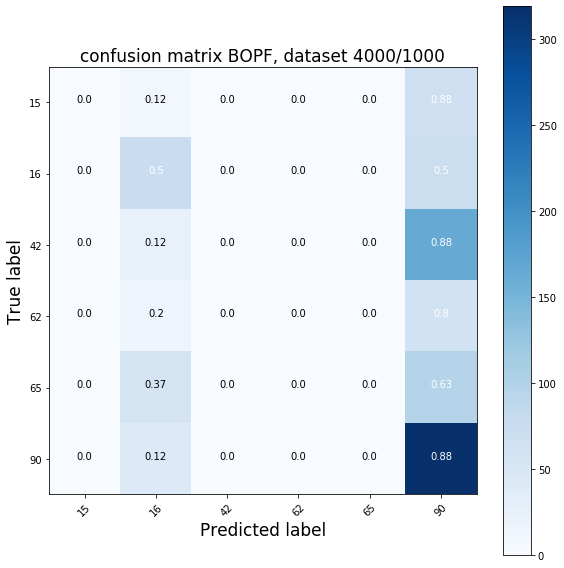

In [41]:

path = "D:/tesis/tesis/data/plasticc_subsets/scenario1_ratio_2-8/"
n1 = 4000
n2 = 1000
c = 6
wd = 3
wl = 0.85

bopf = BagOfPatternFeature(special_character=True)
bopf.load_dataset(path, fmt="npy", set_type="train", n1=n1, c=c)
bopf.cumsum()
    
bopf_t = BagOfPatternFeature(special_character=True)
bopf_t.load_dataset(path, fmt="npy", set_type="test", n1=n2, c=c)
bopf_t.cumsum()

bopf.bop(wd, wl, verbose=False)
bopf.adjust_label_set()
bopf.anova(verbose=False)
bopf.anova_sort()
bopf.sort_trim_arr(verbose=False)
bopf.crossVL(verbose=False)

bopf_t.bop(wd, wl, verbose=False)
print(bopf.best_score)
test_bop_sort = sort_trim_arr(bopf_t.train_bop, bopf.sort_index[:bopf.best_idx],
                                      bopf_t.m, bopf.best_idx)
predicted_label = classify(test_bop_sort, bopf.crossL[:bopf.c * bopf.best_idx], bopf.tlabel,
                                   bopf_t.m, bopf.c, bopf.best_idx)
real_label = np.array(bopf_t.labels)
count = 0 
for j in range(len(real_label)):
    if predicted_label[j] == real_label[j]:
        count += 1
acc = count / len(real_label)
print("accuracy [4000/1000]: ", acc)
cnf_matrix = confusion_matrix(real_label, predicted_label)
np.set_printoptions(precision=2)


class_names = [15, 16, 42, 62, 65, 90]

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='confusion matrix BOPF, dataset %d/%d' % (n1, n2))

print(classification_report(real_label, predicted_label))


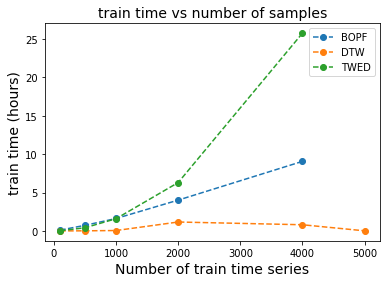

In [53]:
dtw_dist_time = np.array([1.75, 63.82, 250.05, 5574.6, 3857.38, 60.73])
dtw_train_len = [100, 500, 1000, 2000, 4000, 5000]
twed_dist_time = np.array([79.43, 1994.7, 7645.19, 30256.8, 123674.35])
twed_train_len = [100, 500, 1000, 2000, 4000]
bopf_time = np.array(df["train_time"])
bopf_train_len = twed_train_len

acc_dtw = 1 - np.array([0.2, 0.248, 0.28, 0.27, 0.258, 0.2464])
acc_twed = 1 - np.array([0.12, 0.192, 0.28, 0.366, 0.382])
acc_bopf = 1 - np.array(df["acc"])

fig = plt.figure()
plt.plot(bopf_train_len, bopf_time * (6/8) / 60 / 60, 'o--', label="BOPF")
plt.plot(dtw_train_len, dtw_dist_time * (6/8) / 60 / 60, 'o--', label="DTW")
plt.plot(twed_train_len, twed_dist_time * (6/8) / 60 / 60, 'o--', label="TWED")
plt.xlabel("Number of train time series", fontsize=14)
plt.ylabel("train time (hours)", fontsize=14)
plt.title("train time vs number of samples", fontsize=14)
plt.legend()

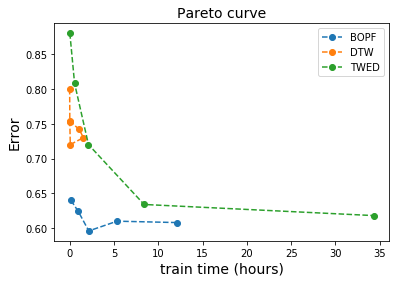

In [56]:
fig = plt.figure()
plt.plot(bopf_time / 60 / 60, acc_bopf, 'o--', label="BOPF")
plt.plot(dtw_dist_time / 60 / 60, acc_dtw, 'o--', label="DTW")
plt.plot(twed_dist_time / 60 / 60, acc_twed, 'o--', label="TWED")
plt.xlabel("train time (hours)", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.title("Pareto curve", fontsize=14)
plt.legend()

### TO-DO on datasets

1. create sub-datasets of same train/test ratio and same number of classes but changing the number of samples
2. create sub-datasets of same number of samples and classes but different train/test ratio
3. execute brute force DTW, brute force TWED and BOPF on same machine for time test